# 5pDEER DEMO
 The aim of this script is to set out the basic design/implemntaion for running incoherent pump pulses on the C Floor AWG.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import autoDeer.hardware.keysight_awg as ksawg
import autoDeer.hardware.pulses as pulses
import autoDeer.hardware.xepr_experiments as exp
import autoDeer.hardware.awg_experiments as awg_exp
from autoDeer.ResPro import resonatorProfile
from autoDeer.FieldSweep import FieldSweep
from autoDeer.hardware import xepr_api as api
import autoDeer.Param_Optimization as po
import time


## Setup

### Connecting to the AWG
The Sequencing mode on both channels should be "STSC"

In [3]:
awg = ksawg.Interface()
awg.open_con('129.132.218.87')
awg._inst_init()
print(f"Checking Sequencing mode:{awg.getFunctionMode(3)}")
sampling_freq = 12e9
sampling_period = 1/sampling_freq
grad = 64


Socket Created
Identification String: b'Agilent Technologies,M8190A,DE52200268,5.0.14.0-2\n'
Checking Sequencing mode:('STSC\n', 'STSC\n')


## Connecting to Bruker

In [4]:
xepr=api() # This can only be run once per kernel
xepr.find_Xepr()
xepr.find_cur_exp()
xepr.find_hidden()

In [15]:
# This sets up the confiuration file of spectrometer
if xepr.hidden['PlsPrgCalDbName'].value != 'Q_awgins2013':
    xepr.hidden['PlsPrgCalDbName'].value = 'Q_awgins2013'
    xepr.hidden['PlsPrgCalDbLoad']
    xepr.hidden['ApplyCfg']

## Initial Tuning of MPFU Channel

In [4]:
exp.run_general(xepr,
    ["/PulseSpel/HUKA_DEER_AWG"],
    ["pi/2 tp=p1 +<x>/-<x>","+<x> (pi/2)"],
    {"PhaseCycle":False},
    {"p0":16,"p1":16,"h":20,"n":2})


temp directory already exists


Replace mode turned on


DANGER: Replace Mode turned ON!


## Resonator Profile

Go to the central frequency of the dip.
Find the rough field maximum and tune +-\<x\> channels for 16ns pulses

In [ ]:
xepr.cur_exp['CenterField'].value = 12220

In [ ]:
settings = {"PhaseCycle":False,"ReplaceMode":False}
settings.keys()

temp directory already exists


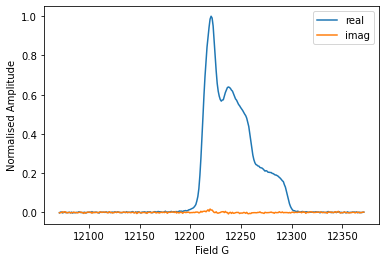

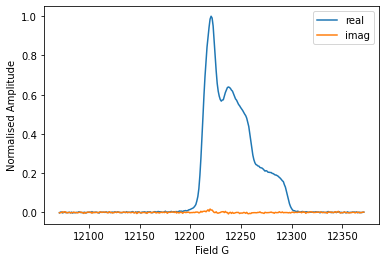

In [4]:
exp.run_general(xepr,
    ["/PulseSpel/HUKA_DEER_AWG"],
    ["Field Sweep +<x>/-<x> pg=200ns","Field sweep +<x>/-<x>"],
    {"PhaseCycle":False,"ReplaceMode":False},
    {"p0":16,"p1":16,"h":25,"n":1,"d0":600})

time.sleep(10)

fs_data = xepr.acquire_scan()
fs = FieldSweep()
fs.import_from_dataclass(fs_data)
fs.find_max()

xepr.set_field(fs.max_field)
Bc = xepr.get_field()
fc = xepr.get_counterfreq()

fs.plot()

Confirm that two consecutative nutation experiments produce the same result. This confirms that everything is set up correctly.

In [ ]:
awg_exp.sequence_nutation(awg,1,1,128,20)

In [11]:
awg.Abort()
awg.StartSigGen(3)

In [4]:
exp.run_general(xepr,
    ["/PulseSpel/HUKA_DEER_AWG"],
    ["AWG seq inv (p2)","AWG +-<x> obs"],
    {"PhaseCycle":True},
    {"p0":16,"p1":16,"h":10,"n":1,"d0":580},False)

time.sleep(2)
xepr.run_exp()
time.sleep(2)
run1 = xepr.acquire_scan()

xepr.run_exp()
time.sleep(2)
run2 = xepr.acquire_scan()
plt.plot(run1.time,np.real(run1.data),
        run2.time,np.real(run2.data))
plt.legend()

temp directory already exists


KeyboardInterrupt: 

Now run the resonator profile script

In [ ]:
t,nutation_data = exp.get_nutations(xepr,
                                    nu=[33, 34],
                                    field=[fc,Bc],
                                    step=20e-3)

In [8]:
xepr.hidden['Frequency'].value

2915.0

Finding and fitting the resonantor profile

In [ ]:
rp = resonatorProfile()
res_prof = rp.calc_res_prof(nutation_data,dt=t[1]-t[0])
rp.autofit([33,35])
rp.calculate_shape(res_prof,None)
rp.calc_IF_prof(2,rp.fc,type='fit')
rp.res_prof_plot([33,35])


Now go to the calculated fc, and do another field sweep. This is the new central frequency

In [ ]:
exp.run_general(xepr,
    ["/PulseSpel/HUKA_DEER_AWG"],
    ["Field Sweep +<x>/-<x> pg=200ns","Field sweep +<x>/-<x>"],
    {"PhaseCycle":False},
    {"p0":16,"p1":16,"h":20,"n":2})

fs_data = xepr.acquire_scan()
fs = FieldSweep()
fs.import_from_dataclass(fs_data)
fs.find_max()
xepr.set_field(fs.field_max)
Bc = xepr.get_field()
fc = xepr.get_counterfreq()
fs.plot()

## Relaxation Experiments

These need to be done on the normal channels. So tune the main channel

In [ ]:
awg.Abort() # Make sure AWG has stopped
po.main_run(xepr,[16,32],d0,)


## DEER Experiments

In [10]:
awg_exp.deer_pulse_5p(awg,100,[2.07,2.32])

Complex Waveform so ignoring channel. Real-> Ch1, Imag -> Ch2
Complex Waveform so ignoring channel. Real-> Ch1, Imag -> Ch2
Complex Waveform so ignoring channel. Real-> Ch1, Imag -> Ch2
Complex Waveform so ignoring channel. Real-> Ch1, Imag -> Ch2
285409280
1627586560


In [17]:
tau2 = 7000
deadtime = 80
scans = 200
awg.StartSigGen(3)
exp.run_general(xepr,
    ["/PulseSpel/HUKA_DEER_AWG"],
    ["5p DEER","DEER run AWG -+<x>"],
    {"PhaseCycle":True,"ReplaceMode":False},
    {"p0":16,"p1":16,"h":20,"n":scans,"d2":tau2,"d11":200,"d3":deadtime})
